In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
from torch.optim import lr_scheduler

import transformers
from transformers.optimization import Adafactor, AdafactorSchedule

from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import os
import random
import time
from tqdm.notebook import tqdm
import datetime as dt
import copy
import matplotlib.pyplot as plt


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='1,2,3,4'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [3]:
model_name_dict = {
    "PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    "biomed_roberta_base": "allenai/biomed_roberta_base",
    "Bio_ClinicalBERT":"emilyalsentzer/Bio_ClinicalBERT",
}

In [4]:
class Hparams:
    def __init__(self):
        self.random_seed = 2021
        self.data_dir = './data'
        self.output_dir = './outputs'
        self.batch_size = 256
        self.token_max_length = 256
        self.model_name = model_name_dict['PubMedBERT']
        self.num_epochs = 10
        self.class_1_weight = 170
        self.initial_lr = 2e-5  # 2e-5
        self.model_type = 'lstm_ex'  # cnn, lstm, lstm_ex
        self.upsample_pos_n = 1
        self.use_col = 'title_abstract'  # title, abstract, title_abstract
        self.train_argument = True

hps = Hparams()

In [5]:
def seed_torch(seed:int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(hps.random_seed)

## Dataframe

In [6]:
orig_df = pd.read_csv(os.path.join(hps.data_dir, 'train.csv'), index_col=0)
submit_df = pd.read_csv(os.path.join(hps.data_dir, 'test.csv'), index_col=0)
sample_submit_df = pd.read_csv(os.path.join(hps.data_dir, 'sample_submit.csv'), index_col=0, header=None, names=['judgement'])

In [7]:
# 修正
orig_df.loc[2488, 'judgement'] = 0
orig_df.loc[7708, 'judgement'] = 0

In [8]:
orig_df['abstract'].fillna('', inplace=True)
orig_df['title_abstract'] = orig_df.title + orig_df.abstract
display(orig_df)
display(orig_df.isna().sum())


submit_df['abstract'].fillna('', inplace=True)
submit_df['title_abstract'] = submit_df.title + submit_df.abstract
submit_df['judgement'] = -1
submit_df.reset_index(inplace=True, drop=False)
display(submit_df)

,title,abstract,judgement,title_abstract
id,,,,
0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,One-year age changes in MRI brain volumes in o...
1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,Supportive CSF biomarker evidence to enhance t...
2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,Occurrence of basal ganglia germ cell tumors w...
3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,New developments in diagnosis and therapy of C...
4,Prolonged shedding of SARS-CoV-2 in an elderly...,,0,Prolonged shedding of SARS-CoV-2 in an elderly...
...,...,...,...,...
27140,The amyloidogenic pathway of amyloid precursor...,Amyloid beta-protein (A beta) is the main cons...,0,The amyloidogenic pathway of amyloid precursor...
27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,0,Technologic developments in radiotherapy and s...
27142,Novel screening cascade identifies MKK4 as key...,Phosphorylation of Tau at serine 422 promotes ...,0,Novel screening cascade identifies MKK4 as key...


title             0
abstract          0
judgement         0
title_abstract    0
dtype: int64

,id,title,abstract,title_abstract,judgement
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...,Estimating the potential effects of COVID-19 p...,-1
1,27146,Leukoerythroblastic reaction in a patient with...,,Leukoerythroblastic reaction in a patient with...,-1
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...,[15O]-water PET and intraoperative brain mappi...,-1
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...,Adaptive image segmentation for robust measure...,-1
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...,Comparison of Epidemiological Variations in CO...,-1
...,...,...,...,...,...
40829,67974,"Knowledge, Attitude, and Practices of Healthca...",In the current outbreak of novel coronavirus (...,"Knowledge, Attitude, and Practices of Healthca...",-1
40830,67975,Safety and Efficacy of Anti-Il6-Receptor Tocil...,BACKGROUND: As the novel SARS-CoV-2 pandemic o...,Safety and Efficacy of Anti-Il6-Receptor Tocil...,-1
40831,67976,Functional imaging of head and neck tumors usi...,Positron emission tomography (PET) is an imagi...,Functional imaging of head and neck tumors usi...,-1
40832,67977,Effectiveness of 3D virtual imaging,,Effectiveness of 3D virtual imaging,-1


In [9]:
train_df, test_df = train_test_split(orig_df, test_size=0.2, random_state=hps.random_seed, shuffle=True, stratify=orig_df.judgement)
train_df, valid_df = train_test_split(train_df, test_size=0.25, random_state=hps.random_seed, shuffle=True, stratify=train_df.judgement)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(f"Train  ->  label_1:{train_df.judgement.sum()} / all:{train_df.judgement.count()}   ({train_df.judgement.sum() / train_df.judgement.count() * 100:.3f}%)")
print(f"Valid  ->  label_1:{valid_df.judgement.sum()} / all:{valid_df.judgement.count()}   ({valid_df.judgement.sum() / valid_df.judgement.count() * 100:.3f}%)")
print(f"Test   ->  label_1:{test_df.judgement.sum()} / all:{test_df.judgement.count()}   ({test_df.judgement.sum() / test_df.judgement.count() * 100:.3f}%)")

Train  ->  label_1:378 / all:16287   (2.321%)
Valid  ->  label_1:126 / all:5429   (2.321%)
Test   ->  label_1:126 / all:5429   (2.321%)


In [10]:
len(train_df) / len(train_df.loc[train_df.judgement==1])

43.08730158730159

## BaseModel

In [11]:
base_tokenizer = transformers.AutoTokenizer.from_pretrained(hps.model_name)

bert_config = transformers.AutoConfig.from_pretrained(hps.model_name)
bert_config.output_hidden_states = True

bert = transformers.AutoModel.from_pretrained(hps.model_name, config=bert_config)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
print(bert_config)

BertConfig {
  "_name_or_path": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Dataset / DataLoader

In [13]:
def text_argument(text, drop_min_seq=3):
    
    
    seq_list = text.split('. ')
    seq_len = len(seq_list)

    if seq_len >= drop_min_seq:
        orig_idx_list = list(range(0, seq_len))
        print('orig_idx_list : ', orig_idx_list)
        idx_list = random.sample(orig_idx_list, random.randint(round(seq_len * 0.7), seq_len))
        idx_list = sorted(idx_list)


        insert_idx_list = random.sample(orig_idx_list, random.randint(0, seq_len//3))
        print('idx_list : ', idx_list)
        print('insert_idx_list : ', insert_idx_list)
        for x in insert_idx_list:
            idx = random.randint(0, len(idx_list))
            idx_list.insert(idx, x)
        print('inserted_idx_list : ', idx_list)

        seq_list = [seq_list[i] for i in idx_list]


    text = '. '.join(seq_list)

    return text

In [14]:
text = train_df.loc[0, 'title_abstract']
argumented_text = text_argument(text)
print('<text>\n', text)
print('\n<argumented text>\n', argumented_text)

orig_idx_list :  [0, 1, 2, 3, 4]
idx_list :  [0, 1, 2, 3, 4]
insert_idx_list :  [4]
inserted_idx_list :  [4, 0, 1, 2, 3, 4]
<text>
 Tracer transport and metabolism in a patient with juvenile pilocytic astrocytoma. A PET studyWe studied a patient with juvenile pilocytic astrocytoma (JPA) using positron emission tomography (PET)  18F-fluorodeoxyglucose (FDG)  11C-methionine (MET)  and 82Rubidium (RUB). Non-linear fitting and multiple time graphical plotting of the dynamic PET data revealed values for tumor plasma volume  blood-brain barrier transport rate constants and tracer distribution volume in the range of glioblastomas and meningiomas  or higher. Likewise  the steady-state accumulation of MET and FDG was increased. With regard to the known vascular composition of JPA  our data suggest that increased transport and distribution considerably contribute to the high net tracer uptake observed in this tumor

<argumented text>
 With regard to the known vascular composition of JPA  our dat

In [15]:
train_df.loc[3, 'title']

'Testing Asymptomatic Emergency Department Patients for Coronavirus of 2019 (COVID-19) in a Low Prevalence Region'

In [16]:
class TextClassificationDataset(Dataset):
    def __init__(self, df, tokenizer, use_col='title_abstract', token_max_length=512, argument=False, upsample_pos_n=1):

        if upsample_pos_n > 1:
            df_pos = df.loc[df.judgement==1]
            df_pos = pd.concat([df_pos for i in range(int(upsample_pos_n))], axis=0).reset_index(drop=True)
            df_neg = df.loc[df.judgement==0]
            self.df = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)
        else:
            self.df = df
        
        self.tokenizer = tokenizer
        self.argument = argument
        self.use_col = use_col

    def text_argument(self, text, drop_min_seq=3, seq_sort=True):
        seq_list = text.split('. ')
        seq_len = len(seq_list)
        if seq_len >= drop_min_seq:
            orig_idx_list = list(range(0, seq_len))
            idx_list = random.sample(orig_idx_list, random.randint(round(seq_len * 0.7), seq_len))
            if seq_sort:
                idx_list = sorted(idx_list)
            insert_idx_list = random.sample(orig_idx_list, random.randint(0, seq_len//3))
            for x in insert_idx_list:
                idx = random.randint(0, len(idx_list))
                idx_list.insert(idx, x)
            seq_list = [seq_list[i] for i in idx_list]
        text = '. '.join(seq_list)
        return text

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        text = self.df.loc[idx, self.use_col]

        if self.argument:
            text = self.text_argument(text, drop_min_seq=3, seq_sort=True)

        token = self.tokenizer.encode_plus(
            text,
            padding = 'max_length', max_length = hps.token_max_length, truncation = True,
            return_attention_mask=True, return_tensors='pt'
        )

        sample = dict(
            input_ids=token['input_ids'][0],
            attention_mask=token['attention_mask'][0]
        )
        
        label = torch.tensor(self.df.loc[idx, 'judgement'], dtype=torch.float32)
        return sample, label
        

In [17]:
phase_param = {
    "df":{'train': train_df, 'val': valid_df, 'test': test_df, 'submit': submit_df},
    "argument":{'train': hps.train_argument, 'val': False, 'test': False, 'submit': False},
    "batch_size":{'train':hps.batch_size, 'val':hps.batch_size*4, 'test':hps.batch_size*4, 'submit': hps.batch_size*4},
    "shuffle":{'train': True, 'val': False, 'test': False, 'submit': False},
    "upsample_pos_n":{'train': hps.upsample_pos_n, 'val': 1, 'test': 1, 'submit': 1},
}

In [18]:
datasets = {phase:TextClassificationDataset(df=phase_param['df'][phase], tokenizer=base_tokenizer, use_col=hps.use_col,\
                                            token_max_length=hps.token_max_length, argument=phase_param['argument'][phase],\
                                            upsample_pos_n=phase_param['upsample_pos_n'][phase]) for phase in ['train', 'val', 'test', 'submit']}

dataloaders = {phase: DataLoader(datasets[phase], batch_size=phase_param['batch_size'][phase], \
                                 shuffle=phase_param['shuffle'][phase]) for phase in ['train', 'val', 'test', 'submit']}

print(len(datasets['train']), len(datasets['val']), len(datasets['test']), len(datasets['submit']))
print(len(dataloaders['train']), len(dataloaders['val']), len(dataloaders['test']), len(dataloaders['submit']))

16287 5429 5429 40834
64 6 6 40


## Model

In [19]:
class BertCnnModel(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.conv1d_1 = nn.Conv1d(hidden_size, 256, kernel_size=2, padding=1)
        self.conv1d_2 = nn.Conv1d(256, 1, kernel_size=2, padding=1)
        self.linear = nn.Linear(258, 1)
    
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = out['last_hidden_state'].permute(0, 2, 1)
        conv_embed = torch.relu(self.conv1d_1(last_hidden_state))
        conv_embed = self.conv1d_2(conv_embed).squeeze()
        logits = torch.sigmoid(self.linear(conv_embed)).squeeze()
        return logits

In [20]:
class BertLstmModel(nn.Module):
    def __init__(self, bert, hidden_size):
        super().__init__()
        self.bert = bert
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.regressor = nn.Linear(hidden_size*2, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(outputs['last_hidden_state'], None)
        out = self.leakyrelu(out)
        sequence_output = out[:, -1, :]
        output = self.dropout(sequence_output)
        logits = torch.flatten(self.regressor(output))
        return logits


In [21]:
class BertLstmExModel(nn.Module):
    def __init__(self, bert, hidden_size, config, use_hidden_n=10):
        super().__init__()
        
        self.bert = bert
        self.hidden_size = hidden_size
        self.use_hidden_n = use_hidden_n
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, batch_first=True, bidirectional=True)
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.conv1d = nn.Conv1d(in_channels=self.use_hidden_n, out_channels=1, kernel_size=3, padding='same')
        self.regressor = nn.Linear(self.hidden_size*2, 1)

        
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states_list = [outputs['hidden_states'][-1*i] for i in range(1, self.use_hidden_n+1)]
        self.lstm.flatten_parameters()
        out_list = [
            self.dropout(
                self.leakyrelu(
                    self.lstm(hidden_state, None)[0]
                )[:, -1, :]
            ).view(-1, 1, self.hidden_size*2)  # (batch, use_hidden_n, hidden_size*2)
        for hidden_state in hidden_states_list]

        out = torch.cat(out_list, dim=1)

        #out = torch.mean(out, dim=1)
        out = self.dropout(self.leakyrelu(self.conv1d(out)))
        out = out.view(out.size(0), -1)

        logits = torch.flatten(self.regressor(out))
        return logits


In [22]:
if hps.model_type == 'cnn':
    print(f"Choosed BertLstmModel")
    model = BertLstmModel(bert=bert, hidden_size=bert_config.hidden_size)
elif hps.model_type == 'lstm':
    print(f"Choosed BertLstmModel")
    model = BertLstmModel(bert=bert, hidden_size=bert_config.hidden_size)
elif hps.model_type == 'lstm_ex':
    print(f"Choosed BertLstmExModel")
    model = BertLstmExModel(bert=bert, hidden_size=bert_config.hidden_size, config=bert_config, use_hidden_n=13)

Choosed BertLstmExModel


In [23]:
inputs, labels = next(iter(dataloaders['train']))
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

#out = model(input_ids, attention_mask)
#print(out.shape)  # bidirectional : True->torch.Size([256, 256, 1536]) / False->torch.Size([256, 256, 768])


In [24]:
class ModelCheckpoint:
    def __init__(self, save_dir:str, model_name:str):
        os.makedirs(save_dir, exist_ok=True)
        self.save_dir = save_dir
        self.model_name = model_name
        jst = dt.timezone(dt.timedelta(hours=+9), 'JST')
        dt_now = dt.datetime.now(jst)
        self.dt_now_str = dt_now.strftime('%Y%m%d_%H%M')
        self.best_loss = self.best_acc = self.best_fbeta_score = 0.0
        self.best_epoch = 0

    def get_checkpoint_name(self, epoch):
        checkpoint_name = f"{self.model_name.replace('/', '_')}__epoch{epoch:03}__{self.dt_now_str}.pth"
        checkpoint_name = os.path.join(self.save_dir, checkpoint_name)
        return checkpoint_name

    def save_checkpoint(self, model, epoch):
        torch.save(model.state_dict(), self.get_checkpoint_name(epoch))

    def load_checkpoint(self, model=None, epoch=1, manual_name=None):
        if manual_name is None:
            checkpoint_name = self.get_checkpoint_name(epoch)
        else:
            checkpoint_name = manual_name
        print(checkpoint_name)
        model.load_state_dict(torch.load(checkpoint_name))
        return model

In [25]:
def fit(dataloaders, model, optimizer, num_epochs, device, batch_size, lr_scheduler):

    history = {
        'train':{'loss':[], 'acc':[], 'fbscore':[]},
        'val':{'loss':[], 'acc':[], 'fbscore':[]},
        'lr':[],
    }

    checkpoint = ModelCheckpoint(save_dir='model_weights', model_name=hps.model_name)
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Using device : {device}")
    for epoch in range(num_epochs):
        print(f"【Epoch {epoch+1: 3}/{num_epochs: 3}】   LR -> ", end='')
        for i, params in enumerate(optimizer.param_groups):
            print(f"Group{i}: {params['lr']:.4e}", end=' / ')
        print('')

        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            running_fbeta_score = 0.0
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                input_ids = inputs['input_ids']
                attention_mask = inputs['attention_mask']
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    logits_outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    pos_weight = torch.tensor([hps.class_1_weight for i in range(input_ids.size(0))]).to(device)
                    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
                    loss = criterion(logits_outputs, labels)

                    outputs = torch.sigmoid(logits_outputs)
                    preds = torch.where(outputs >= 0.5, 1, 0)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr_scheduler.step()

                running_loss += loss.item() * input_ids.size(0)
                running_corrects += torch.sum(preds == labels)
                running_fbeta_score += fbeta_score(labels.to('cpu').detach().numpy(), preds.to('cpu').detach().numpy(), beta=7.0, zero_division=0) * input_ids.size(0)    

                if phase == 'train':
                    if i % 10 == 9:
                        total_num = float((i * batch_size) + input_ids.size(0))
                        print(f"{i+1: 4}/{len(dataloaders[phase]): 4}  <{phase}> Loss:{(running_loss/total_num):.4f}  Acc:{(running_corrects/total_num):.4f}  fbScore:{(running_fbeta_score/total_num):.4f}   LR -> ", end='')
                        for i, params in enumerate(optimizer.param_groups):
                            print(f"Group{i}: {params['lr']:.4e}", end=' / ')
                            if isinstance(optimizer.param_groups[0]['lr'], float):
                                history['lr'].append(optimizer.param_groups[0]['lr'])
                            else:
                                history['lr'].append(optimizer.param_groups[0]['lr'].item())
                        print('')

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_fbscore = running_fbeta_score / len(dataloaders[phase].dataset)
            
            print(f"<{phase}> Loss:{epoch_loss:.4f}  Acc:{epoch_acc:.4f}  fbScore:{epoch_fbscore:.4f}")

            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.item())
            history[phase]['fbscore'].append(epoch_fbscore)


            if phase == 'val' and epoch_fbscore > checkpoint.best_fbeta_score:
                print(f"Checkpoints have been updated to the epoch {epoch+1} weights.")
                checkpoint.best_loss = epoch_loss
                checkpoint.best_acc = epoch_acc
                checkpoint.best_fbeta_score = epoch_fbscore
                checkpoint.best_epoch = epoch+1
                best_model_wts = copy.deepcopy(model.state_dict())

        print('-' * 150)

    model.load_state_dict(best_model_wts)
    checkpoint.save_checkpoint(model, epoch)
    torch.cuda.empty_cache()

    return model, history

In [26]:
model = model.to(device)



# optimizer = optim.AdamW(model.parameters(), lr=hps.initial_lr)

optimizer = optim.AdamW(
    params=[
        {'params': model.bert.embeddings.parameters(), 'lr': 1e-5},
        {'params': model.bert.encoder.parameters(), 'lr': 3e-5},
        {'params': model.bert.pooler.parameters(), 'lr': 5e-5},
        {'params': model.lstm.parameters(), 'lr': 5e-4},
        {'params': model.conv1d.parameters(), 'lr': 5e-4},
        {'params': model.regressor.parameters(), 'lr': 1e-3}
    ]
)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


#optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
#lr_scheduler = AdafactorSchedule(optimizer)

# https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup

num_warmup_steps = round(hps.num_epochs * len(dataloaders['train']) * 0.1)
num_training_steps = round(hps.num_epochs * len(dataloaders['train']))
print(f"InitLR:{hps.initial_lr} / num_warmup_steps:{num_warmup_steps} / num_training_steps:{num_training_steps}")
lr_scheduler = transformers.get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, 
                                                            num_training_steps=num_training_steps, last_epoch=-1)



device_num = torch.cuda.device_count()
if device_num > 1:
    print(f"Use {device_num} GPUs")
    model = nn.DataParallel(model)

model, history = fit(dataloaders=dataloaders, model=model,
              optimizer=optimizer, num_epochs=hps.num_epochs, device=device, batch_size=hps.batch_size, lr_scheduler=lr_scheduler)

InitLR:2e-05 / num_warmup_steps:64 / num_training_steps:640
Use 4 GPUs
Using device : cuda
【Epoch   1/ 10】   LR -> Group0: 0.0000e+00 / Group1: 0.0000e+00 / Group2: 0.0000e+00 / Group3: 0.0000e+00 / Group4: 0.0000e+00 / Group5: 0.0000e+00 / 


  0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

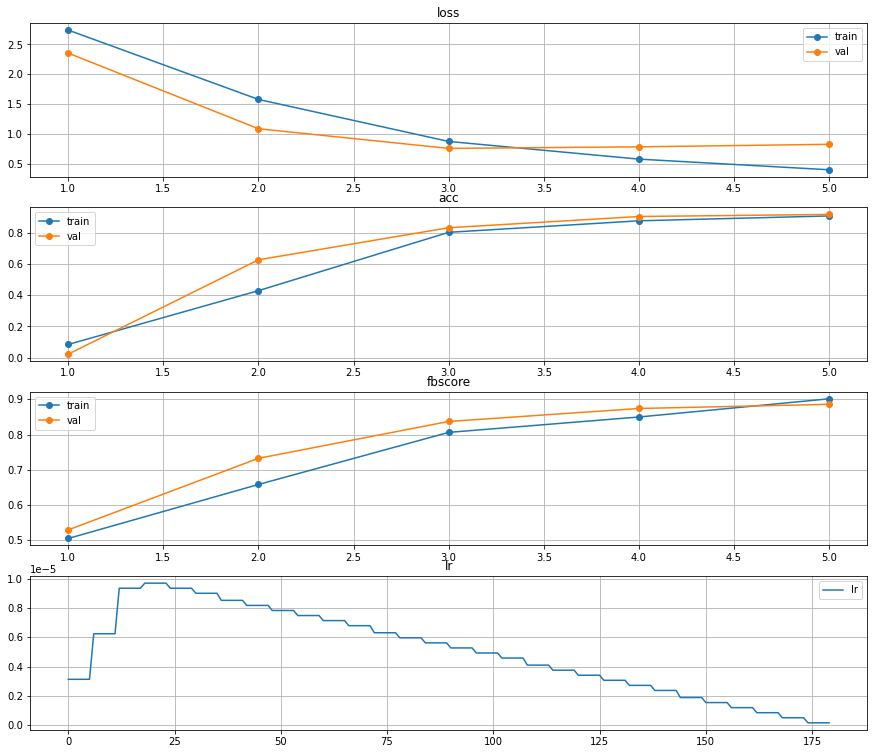

In [ ]:
def history_plot(history):
    fig = plt.figure(figsize=(15, 13))
    
    for i, metric in enumerate(['loss', 'acc', 'fbscore']):
        ax = fig.add_subplot(4, 1, i+1)
        ax.set_title(metric)
        for phase in ['train', 'val']:
            ax.plot([i+1 for i in range(hps.num_epochs)], history[phase][metric], label=phase, marker='o')
        ax.legend()
        ax.grid()

    ax = fig.add_subplot(4, 1, 4)
    ax.set_title('lr')
    ax.plot(history['lr'], label='lr')
    ax.legend()
    ax.grid()

    fig.show()

history_plot(history)

## Evaluate test dataset

In [ ]:
def inference(model, dataloader, device, evaluate=True):
    
    running_loss = 0.0
    running_corrects = 0
    running_fbeta_score = 0.0

    preds_labels_dict = dict(preds = np.empty(0), labels = np.empty(0))

    model.eval()

    for i, (inputs, labels) in enumerate(tqdm(dataloader)):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits_outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            if evaluate:
                pos_weight = torch.tensor([hps.class_1_weight for i in range(input_ids.size(0))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
                loss = criterion(logits_outputs, labels)

            outputs = torch.sigmoid(logits_outputs)
            preds = torch.where(outputs >= 0.5, 1, 0)
            
            if evaluate:
                running_loss += loss.item() * input_ids.size(0)
                running_corrects += torch.sum(preds == labels)
                running_fbeta_score += fbeta_score(labels.to('cpu').detach().numpy(), preds.to('cpu').detach().numpy(), beta=7.0, zero_division=0) * input_ids.size(0)

            preds_labels_dict['preds']  = np.hstack([preds_labels_dict['preds'], preds.to('cpu').detach().numpy().copy()])
            preds_labels_dict['labels']  = np.hstack([preds_labels_dict['labels'], labels.to('cpu').detach().numpy().copy()])
    
    if evaluate:
        loss = running_loss / len(dataloader.dataset)
        acc = running_corrects / len(dataloader.dataset)
        fbscore = running_fbeta_score / len(dataloader.dataset)
        print(f"Loss:{loss:.4f}  Acc:{acc:.4f}  fbScore:{fbscore:.4f}")
    return preds_labels_dict


In [ ]:
test_preds_labels_dict = inference(model, dataloader=dataloaders['test'], device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

Loss:0.9217  Acc:0.9083  fbScore:0.8823


In [ ]:
cm = confusion_matrix(y_true=test_preds_labels_dict['labels'], y_pred=test_preds_labels_dict['preds'])
cm_df = pd.DataFrame(cm)
cm_df.columns = pd.MultiIndex.from_arrays([["Predicted", ""], ['label:0', 'label:1']])
cm_df.index = pd.MultiIndex.from_arrays([["Actual", ""], ['label:0', 'label:1']])
display(cm_df)

,,Predicted,
,,label:0,label:1
Actual,label:0,4811,492
,label:1,6,120


In [ ]:
test_fb_score = fbeta_score(y_true=test_preds_labels_dict['labels'], y_pred=test_preds_labels_dict['preds'], beta=7.0)
print('fb_score : ', test_fb_score)

fb_score :  0.8841732979664015


In [ ]:
print(vars(hps))

{'random_seed': 2021, 'data_dir': './data', 'output_dir': './outputs', 'batch_size': 256, 'token_max_length': 256, 'model_name': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', 'num_epochs': 5, 'class_1_weight': 170, 'initial_lr': 2e-05, 'model_type': 'lstm_ex', 'upsample_pos_n': 1, 'use_col': 'title_abstract', 'train_argument': True}


## Submit

In [ ]:
submit_preds_labels_dict = inference(model, dataloader=dataloaders['submit'], device=device, evaluate=False)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
submit_preds_labels_dict['preds']

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
sample_submit_df['judgement'] = [int(i) for i in submit_preds_labels_dict['preds']]

In [ ]:
sample_submit_df

,judgement
27145,0
27146,0
27147,0
27148,0
27149,0
...,...
67974,0
67975,0
67976,0
67977,0


In [ ]:
sample_submit_df.describe()

,judgement
count,40834.000000
mean,0.103468
std,0.304572
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
jst = dt.timezone(dt.timedelta(hours=+9), 'JST')
dt_now = dt.datetime.now(jst)
dt_now_str = dt_now.strftime('%Y%m%d_%H%M')
submit_str = f"{dt_now_str}_{test_fb_score:.4f}".replace('.', '-')
submit_str = f"{submit_str}.csv"
print(submit_str)

os.makedirs('./submit', exist_ok=True)
sample_submit_df.to_csv(os.path.join('submit', submit_str), header=False)

20210927_1551_0-8842.csv
